<a href="https://colab.research.google.com/github/aruzhankenzhebek/Pothole_Detection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/My Drive/Pothole_Dataset'


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Пути к папкам
base_path = '/content/drive/My Drive/Pothole_Dataset'
normal_source = os.path.join(base_path, 'normal')
potholes_source = os.path.join(base_path, 'potholes')

train_normal = os.path.join(base_path, 'train/normal')
train_potholes = os.path.join(base_path, 'train/potholes')
val_normal = os.path.join(base_path, 'val/normal')
val_potholes = os.path.join(base_path, 'val/potholes')

# Создай целевые папки
os.makedirs(train_normal, exist_ok=True)
os.makedirs(train_potholes, exist_ok=True)
os.makedirs(val_normal, exist_ok=True)
os.makedirs(val_potholes, exist_ok=True)

# Функция для перемещения данных
def split_and_move_files(source, train_dest, val_dest, split_ratio=0.8):
    files = os.listdir(source)
    train_files, val_files = train_test_split(files, test_size=1-split_ratio)

    for file in train_files:
        shutil.move(os.path.join(source, file), train_dest)
    for file in val_files:
        shutil.move(os.path.join(source, file), val_dest)

# Раздели данные
split_and_move_files(normal_source, train_normal, val_normal)
split_and_move_files(potholes_source, train_potholes, val_potholes)


ValueError: With n_samples=0, test_size=0.19999999999999996 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
from torchvision import datasets, transforms
import torch

# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Приведение размера изображений
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

# Пути к разделенным данным
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')

# Загрузка тренировочных и валидационных данных
train_data = datasets.ImageFolder(train_path, transform=transform)
val_data = datasets.ImageFolder(val_path, transform=transform)

# DataLoader для работы с данными
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)

# Проверим количество изображений
print(f"Количество тренировочных изображений: {len(train_data)}")
print(f"Количество валидационных изображений: {len(val_data)}")

Количество тренировочных изображений: 544
Количество валидационных изображений: 137


In [ ]:
from torchvision import models
import torch.nn as nn

# Загрузка предобученной модели ResNet18
model = models.resnet18(pretrained=True)

# Настройка последнего слоя под количество классов (2: normal и potholes)
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Перенос модели на GPU (если доступен)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Тренировка
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracy = correct_train / total_train

        # Валидация
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Логирование
        print(f"Эпоха {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_accuracies

# Запуск обучения базовой модели
train_losses, val_accuracies = train_model(baseline_model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Эпоха 1/5
Train Loss: 0.0211, Train Accuracy: 0.9945
Val Loss: 0.0789, Val Accuracy: 0.9854
Эпоха 2/5
Train Loss: 0.0311, Train Accuracy: 0.9871
Val Loss: 0.0745, Val Accuracy: 0.9854
Эпоха 3/5
Train Loss: 0.0417, Train Accuracy: 0.9871
Val Loss: 0.0662, Val Accuracy: 0.9854
Эпоха 4/5
Train Loss: 0.0270, Train Accuracy: 0.9890
Val Loss: 0.0802, Val Accuracy: 0.9854
Эпоха 5/5
Train Loss: 0.0240, Train Accuracy: 0.9908
Val Loss: 0.0710, Val Accuracy: 0.9854


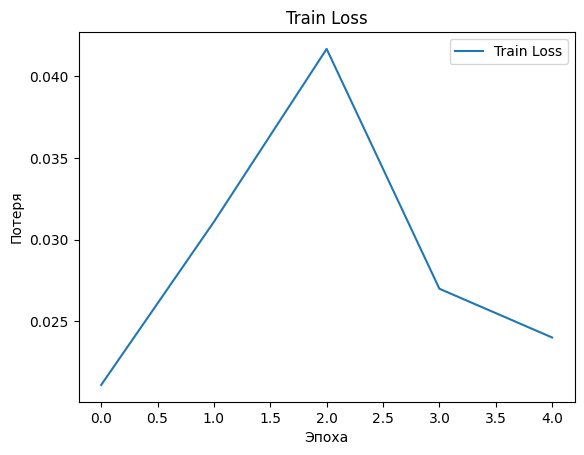

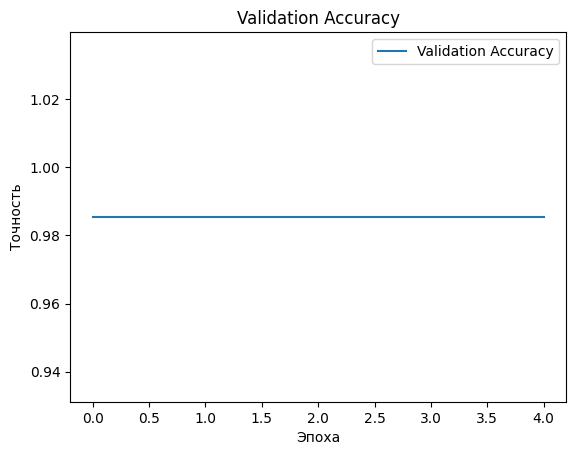

In [ ]:
# График потерь
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.title('Train Loss')
plt.show()

# График точности
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


In [ ]:
class EnhancedModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(EnhancedModel, self).__init__()
        # Используем все слои, кроме Fully Connected
        self.features = nn.Sequential(*list(base_model.children())[:-2])  # Убираем AdaptiveAvgPool2d и FC

        # Определяем выходные каналы из последнего сверточного слоя
        last_conv_out_channels = 512  # Для ResNet18 это фиксированное значение

        # Добавляем Batch Normalization
        self.bn = nn.BatchNorm2d(last_conv_out_channels)

        # Новый Fully Connected блок
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(last_conv_out_channels, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.bn(x)  # Batch Normalization
        x = self.fc(x)
        return x

# Создаем улучшенную модель
enhanced_model = EnhancedModel(models.resnet18(pretrained=True), num_classes)
enhanced_model = enhanced_model.to(device)

# Оптимизатор
optimizer_enhanced = torch.optim.Adam(enhanced_model.parameters(), lr=0.001)

# Обучение улучшенной модели
train_losses_enh, val_accuracies_enh = train_model(
    enhanced_model, train_loader, val_loader, criterion, optimizer_enhanced, num_epochs=5
)


Эпоха 1/5
Train Loss: 0.2419, Train Accuracy: 0.9228
Val Loss: 1.9312, Val Accuracy: 0.6788
Эпоха 2/5
Train Loss: 0.1444, Train Accuracy: 0.9430
Val Loss: 0.4187, Val Accuracy: 0.8613
Эпоха 3/5
Train Loss: 0.0903, Train Accuracy: 0.9651
Val Loss: 0.3972, Val Accuracy: 0.9051
Эпоха 4/5
Train Loss: 0.0841, Train Accuracy: 0.9632
Val Loss: 0.5616, Val Accuracy: 0.9343
Эпоха 5/5
Train Loss: 0.0584, Train Accuracy: 0.9779
Val Loss: 0.0543, Val Accuracy: 0.9854


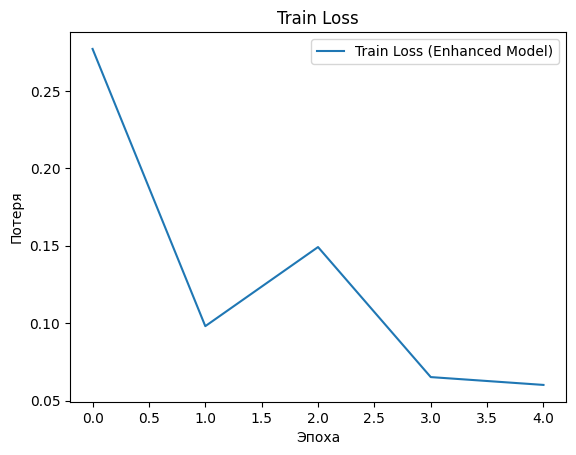

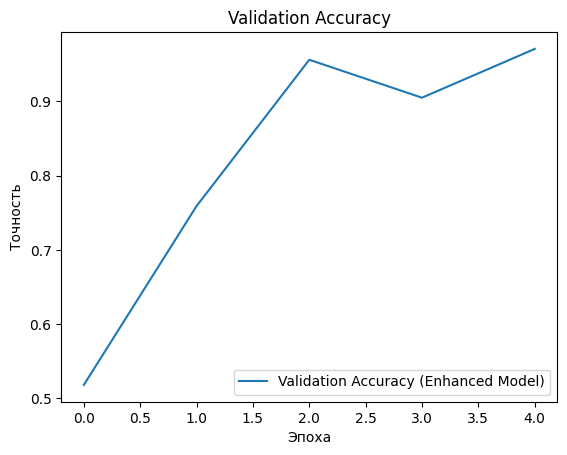

In [ ]:
# График потерь (Train Loss)
plt.plot(train_losses_enh, label='Train Loss (Enhanced Model)')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.title('Train Loss')
plt.show()

# График точности (Val Accuracy)
plt.plot(val_accuracies_enh, label='Validation Accuracy (Enhanced Model)')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


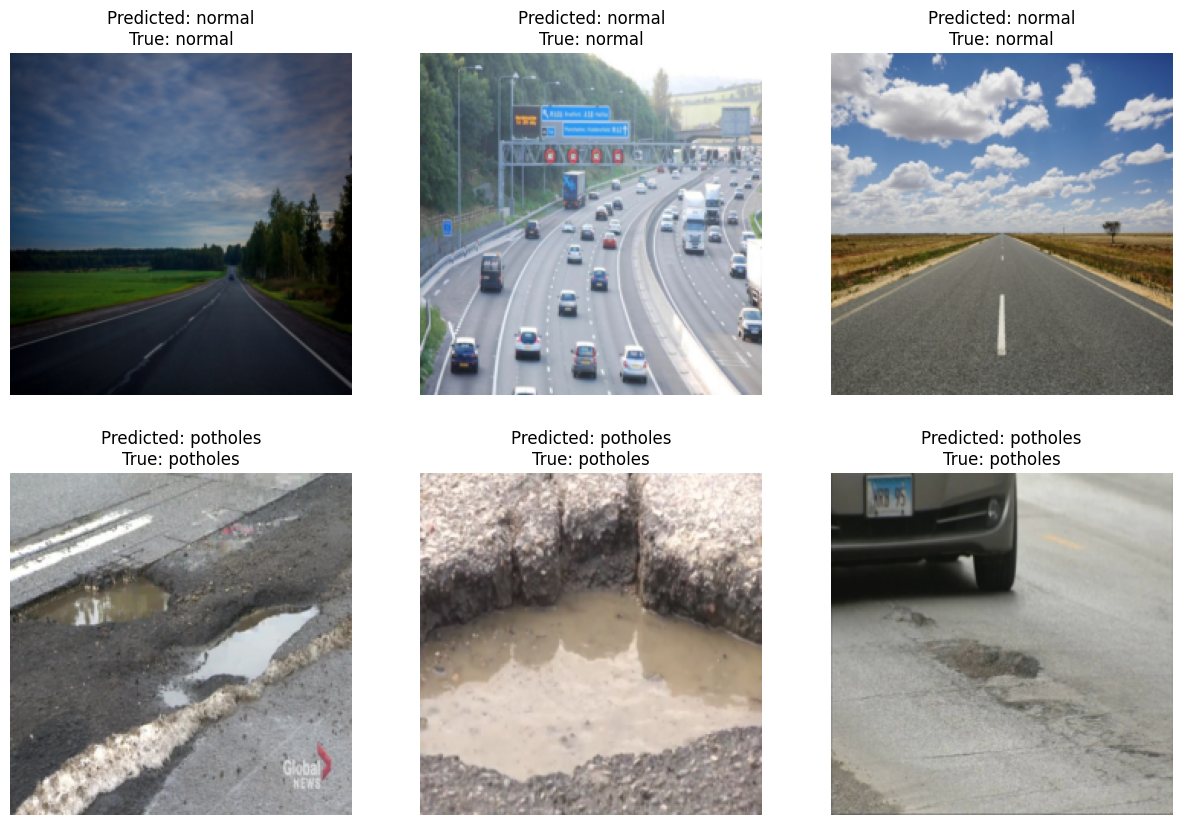

In [103]:
def visualize_predictions_balanced(model, loader, num_images=5):
    model.eval()
    potholes_displayed = 0
    normal_displayed = 0
    max_per_class = num_images // 2  # Сколько изображений из каждой категории

    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                true_class = labels[i].item()
                predicted_class = preds[i].item()

                # Условия для отображения классов
                if true_class == 0 and normal_displayed < max_per_class:  # "normal"
                    normal_displayed += 1
                elif true_class == 1 and potholes_displayed < max_per_class:  # "potholes"
                    potholes_displayed += 1
                else:
                    continue

                # Подготовка изображения
                img = inputs[i].cpu().permute(1, 2, 0)  # Перестановка каналов для matplotlib
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Деинормализация
                img = img.numpy()

                # Отображение
                plt.subplot(2, num_images // 2, potholes_displayed + normal_displayed)
                plt.imshow(np.clip(img, 0, 1))
                plt.title(f"Predicted: {train_data.classes[predicted_class]}\nTrue: {train_data.classes[true_class]}")
                plt.axis('off')

                # Завершаем, если достигли лимита
                if potholes_displayed == max_per_class and normal_displayed == max_per_class:
                    break

    plt.show()

# Вызов функции
visualize_predictions_balanced(enhanced_model, val_loader, num_images=6)


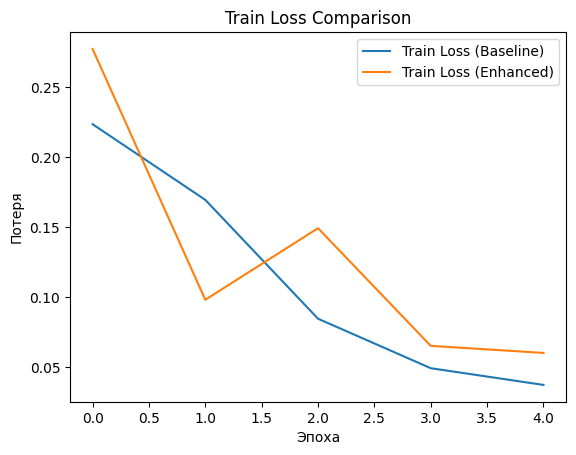

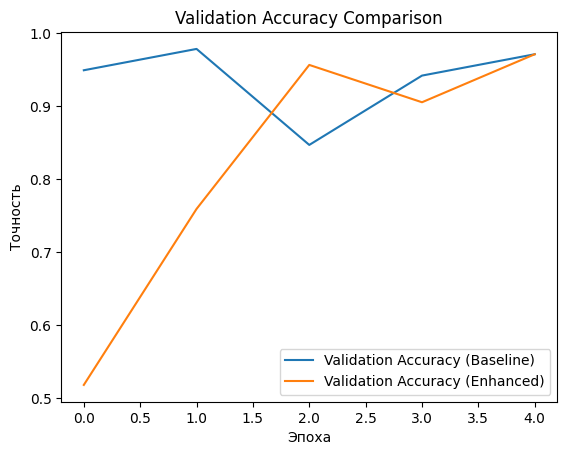

In [ ]:
# Сравнение графиков потерь
plt.plot(train_losses, label='Train Loss (Baseline)')
plt.plot(train_losses_enh, label='Train Loss (Enhanced)')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.title('Train Loss Comparison')
plt.show()

# Сравнение точности
plt.plot(val_accuracies, label='Validation Accuracy (Baseline)')
plt.plot(val_accuracies_enh, label='Validation Accuracy (Enhanced)')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.show()


In [104]:
from sklearn.metrics import f1_score, precision_score, recall_score

def calculate_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    return f1, precision, recall

# Вычисление метрик
f1, precision, recall = calculate_metrics(enhanced_model, val_loader)
print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


F1 Score: 0.9854, Precision: 0.9858, Recall: 0.9854


In [105]:
# Сохранение модели
torch.save(enhanced_model.state_dict(), "enhanced_model.pth")
